In [1]:
import pandas as pd
import seaborn as sns
import re
from glob import glob
import networkx as nx
from matplotlib import pyplot as plt
from collections import Counter

In [2]:
out_files = glob('../data/lrmi-crawler-third-full/out/**/*.gz')

In [3]:
triples = []
for out_file in out_files:
    _, _, _, _, year, source_file_name = out_file.split('/')
    trip_type = source_file_name.replace('dpef.html-', '').split('.nq')[0]
    with open(out_file, 'r') as f:
        for l in f:
            trip = l[:-1].split('\t')
            trip.append(year)
            trip.append(source_file_name)
            trip.append(trip_type)
            triples.append(trip)

In [4]:
total_triples = len(triples)

### Extraction Error Analysis

In [5]:
# % of triples with ,s
clean_triples = [t for t in triples if len(t) == 7]
clean_triples_count = len(clean_triples)
clean_triples_count, total_triples, (total_triples - clean_triples_count) / total_triples * 100

(1502870, 1502870, 0.0)

### Clean Dataset

In [6]:
df = pd.DataFrame(clean_triples, columns=['s', 'p', 'o', 'url', 'year', 'source', 'tipe'])

In [7]:
df['simple_p'] = df.p.str.extract('.*/([a-zA-Z]+)>')[0]

In [8]:
df['domain'] = df.url.str.extract('<http.*://(.*?)/.*>')[0]

### Counts by year

#### Totals

In [9]:
df.groupby('year').s.count().rename('triples_per_year')

year
2019    500509
2020    444750
2021    557611
Name: triples_per_year, dtype: int64

#### Broken down by predicate

In [10]:
total_p_counts = df.simple_p.value_counts().rename('total')
def ordered_p_counts(df):
    counts = df.simple_p.value_counts()
    ordered_counts = [counts.get(p) for p in total_p_counts.index]
    return pd.Series(ordered_counts, index=total_p_counts.index)

pd.concat([df.groupby('year').apply(ordered_p_counts), total_p_counts.to_frame().transpose()], axis=0).transpose()

,2019,2020,2021,total
timeRequired,110466.0,134135.0,179257.0,423858.0
typicalAgeRange,83128.0,109881.0,111013.0,304022.0
learningResourceType,76042.0,43546.0,47305.0,166893.0
educationalUse,69422.0,34923.0,28289.0,132634.0
isBasedOnUrl,48709.0,22033.0,27907.0,98649.0
educationalRole,50709.0,25956.0,19727.0,96392.0
interactivityType,20467.0,31358.0,39958.0,91783.0
alignmentType,11996.0,10087.0,23335.0,45418.0
educationalAlignment,8813.0,12525.0,23468.0,44806.0
targetName,9545.0,8689.0,23059.0,41293.0


#### Broken down by provider

In [11]:
total_domain_counts = df.domain.value_counts().rename('total')
def ordered_domain_counts(df):
    counts = df.domain.value_counts()
    ordered_counts = [counts.get(d) for d in total_domain_counts.index]
    return pd.Series(ordered_counts, index=total_domain_counts.index)

pd.concat([df.groupby('year').apply(ordered_domain_counts), 
           total_domain_counts.to_frame().transpose()
          ], axis=0).transpose().head(15)

,2019,2020,2021,total
www.litcharts.com,70108.0,21854.0,9394.0,101356.0
www.math-drills.com,37936.0,11088.0,5728.0,54752.0
www.pbslearningmedia.org,NaN,NaN,38622.0,38622.0
www.mathslibres.com,19040.0,6640.0,5552.0,31232.0
spiral.ac,NaN,12710.0,17690.0,30400.0
www.mateslibres.com,12944.0,7280.0,7984.0,28208.0
replay.lsm.lv,NaN,13035.0,13970.0,27005.0
www.goconqr.com,3062.0,1302.0,19209.0,23573.0
www.tabletennis365.com,12914.0,3010.0,5074.0,20998.0
www.commonsense.org,11602.0,3071.0,3907.0,18580.0


<AxesSubplot:>

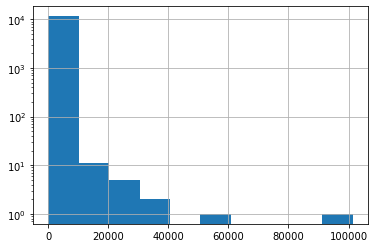

In [12]:
total_domain_counts.hist(log=True)

### Counts of predicates per domain for top domains for one year

In [13]:
counts_per_domain_predicate = df[df.year == '2019'].groupby(['domain', 'simple_p']).s.count()\
    .rename('counts')\
    .reset_index()\
    .pivot_table(index='domain', columns='simple_p')

counts_per_domain_predicate['totals'] = counts_per_domain_predicate.sum(axis=1)
counts_per_domain_predicate = counts_per_domain_predicate.sort_values(by='totals', ascending=False)
counts_per_domain_predicate.iloc[:10]

counts                                     \
simple_p               aggregateRating alignmentType educationalAlignment   
domain                                                                      
www.litcharts.com                  NaN           NaN                  NaN   
www.math-drills.com                NaN           NaN                  NaN   
www.mathslibres.com                NaN           NaN                  NaN   
www.mateslibres.com                NaN           NaN                  NaN   
www.tabletennis365.com             NaN           NaN                  NaN   
tabletennis365.com                 NaN           NaN                  NaN   
www.commonsense.org                NaN        2228.0               2228.0   
www.ck12.org                       NaN           NaN                  NaN   
www.getabstract.com                NaN           NaN                  NaN   
www.sondakika.com                  NaN           NaN                  NaN   

                                                                              \
simple_p               educationalFramework educationalLevel educationalRole   
domain                                                                         
www.litcharts.com                       NaN              NaN         29810.0   
www.math-drills.com                     NaN              NaN          7113.0   
www.mathslibres.com                     NaN              NaN          3570.0   
www.mateslibres.com                     NaN              NaN          2427.0   
www.tabletennis365.com                  NaN              NaN             NaN   
tabletennis365.com                      NaN              NaN             NaN   
www.commonsense.org                  2160.0              NaN          1828.0   
www.ck12.org                            NaN              NaN             NaN   
www.getabstract.com                     NaN              NaN             NaN   
www.sondakika.com                       NaN              NaN             NaN   

                                                                      \
simple_p               educationalUse interactivityType isBasedOnUrl   
domain                                                                 
www.litcharts.com                 NaN               NaN          NaN   
www.math-drills.com           28452.0               NaN          NaN   
www.mathslibres.com           14280.0               NaN          NaN   
www.mateslibres.com            9708.0               NaN          NaN   
www.tabletennis365.com            NaN               NaN      12914.0   
tabletennis365.com                NaN               NaN      12912.0   
www.commonsense.org             944.0               NaN          NaN   
www.ck12.org                      1.0            3006.0          NaN   
www.getabstract.com               NaN               NaN          NaN   
www.sondakika.com                 NaN               NaN          NaN   

                                                                               \
simple_p               learningResourceType name targetDescription targetName   
domain                                                                          
www.litcharts.com                   40298.0  NaN               NaN        NaN   
www.math-drills.com                  2371.0  NaN               NaN        NaN   
www.mathslibres.com                  1190.0  NaN               NaN        NaN   
www.mateslibres.com                   809.0  NaN               NaN        NaN   
www.tabletennis365.com                  NaN  NaN               NaN        NaN   
tabletennis365.com                      NaN  NaN               NaN        NaN   
www.commonsense.org                    36.0  NaN               NaN     2160.0   
www.ck12.org                         2417.0  NaN               NaN        NaN   
www.getabstract.com                  4758.0  NaN               NaN        NaN   
www.sondakika.com                       NaN  NaN               NaN        NaN   

### Co-occurence

In [14]:
predicates = [p for p in counts_per_domain_predicate.columns.get_level_values(1) if p]

In [15]:
predicates

['aggregateRating',
 'alignmentType',
 'educationalAlignment',
 'educationalFramework',
 'educationalLevel',
 'educationalRole',
 'educationalUse',
 'interactivityType',
 'isBasedOnUrl',
 'learningResourceType',
 'name',
 'targetDescription',
 'targetName',
 'targetURL',
 'timeRequired',
 'typicalAgeRange',
 'useRightsURL']

In [16]:
edge_weights = dict()

for node1 in predicates:
    for node2 in predicates:
        if node1 != node2:
            edge_weights[(node1, node2)] = counts_per_domain_predicate[
                counts_per_domain_predicate['counts'][node1].notna() &
                counts_per_domain_predicate['counts'][node2].notna()
            ].shape[0]

In [17]:
G = nx.Graph()
for p in predicates:
    G.add_node(p)
for p1, p2 in edge_weights:
    if p1 >= p2:
        if edge_weights[(p1, p2)] > 0:
            G.add_edge(p1, p2, weight=edge_weights[(p1, p2)])

In [18]:
edge_weight_values = pd.Series(list(edge_weights.values())).value_counts().iloc[1:].unique()

In [19]:
sequential_colors = [
    "#F5E700",
    "#D4B204",
    "#EBAF08",
    "#D68802",
    "#FA7E02",
    "#EB5301",
    "#D63109",
    "#FA150A"
]

In [20]:
edge_weight_to_color = dict(zip(edge_weight_values, sequential_colors))

In [21]:
def translate(x, y, pos):
    out = dict()
    for k in pos:
        out[k] = [pos[k][0] + x, pos[k][1] + y]
    return out

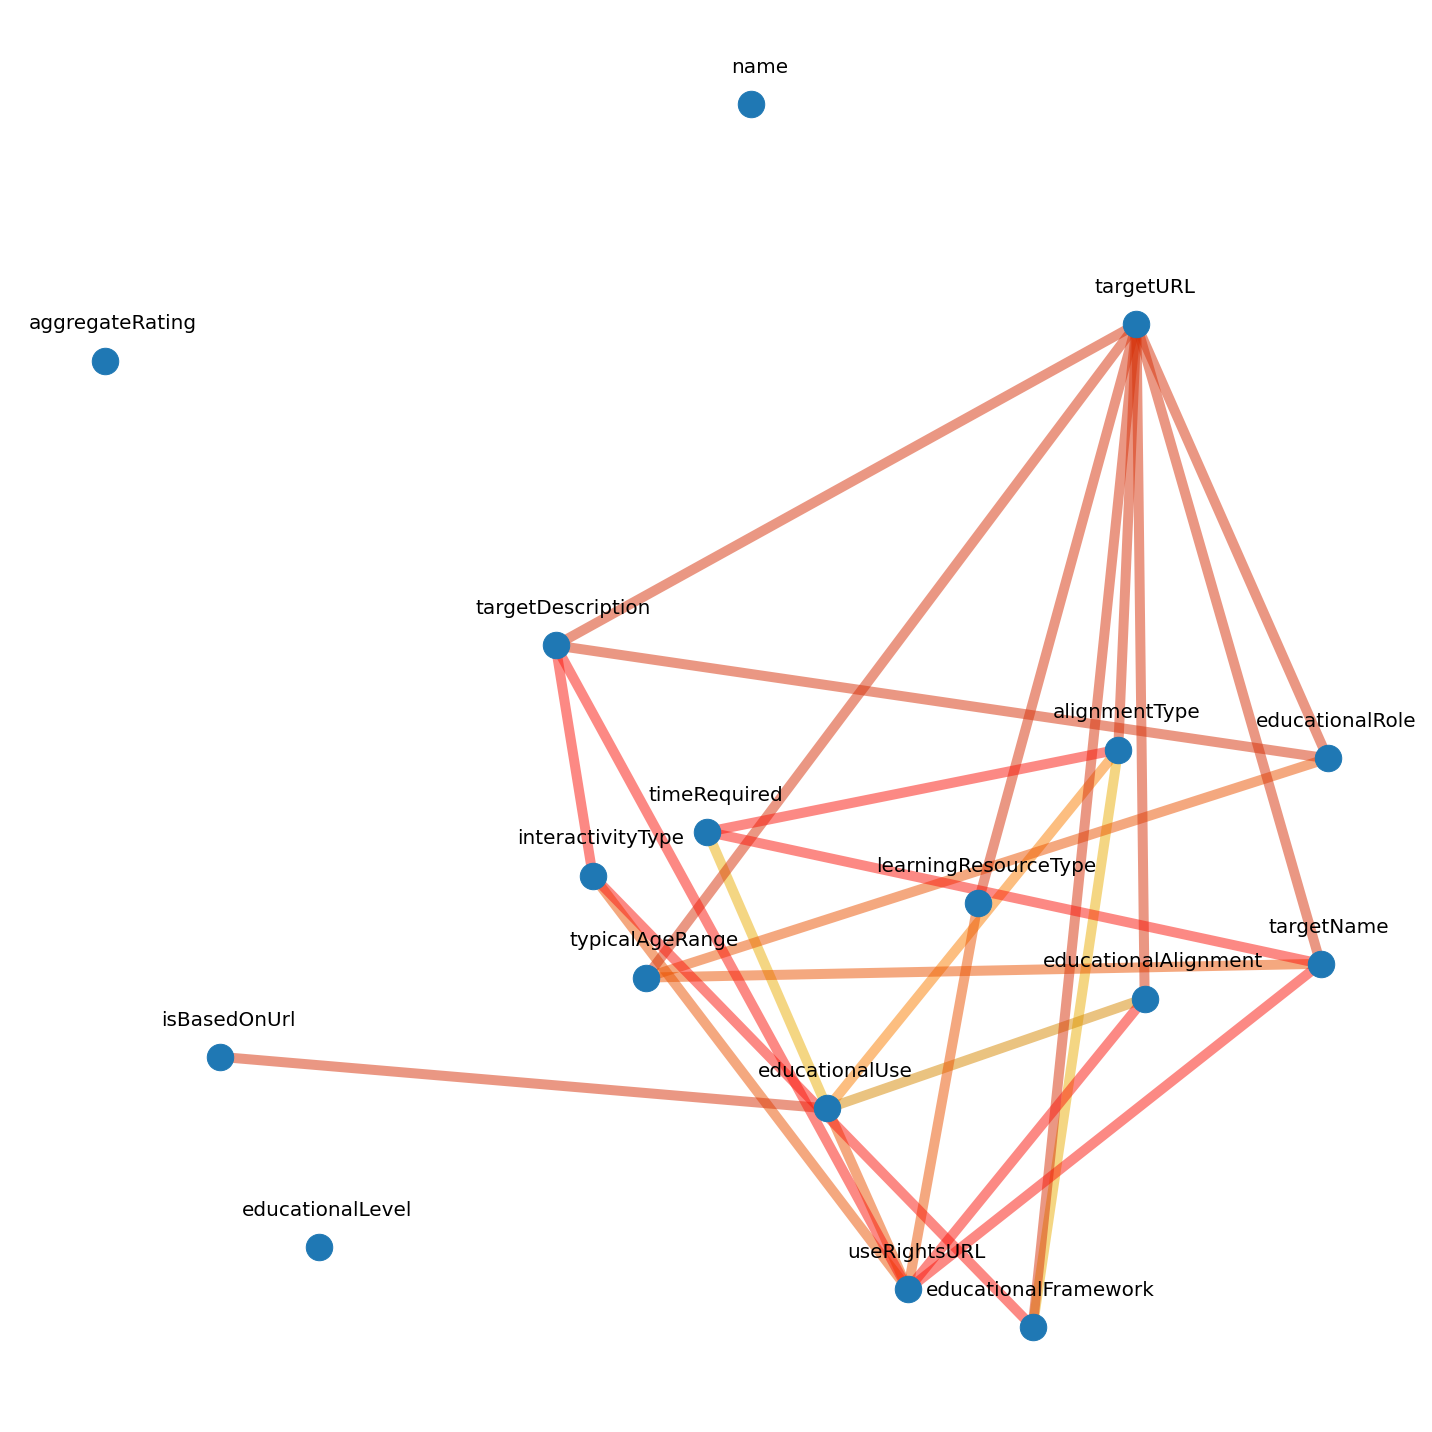

In [22]:
edges_by_weight = [(
    edge_weight_to_color[w], 
    [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] == w]
) for w in edge_weight_values]

pos = nx.spring_layout(G, seed=7, k=3.9)  # positions for all nodes - seed for reproducibility

plt.subplots(figsize=(20, 20))

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
for edge_color, edge_set in edges_by_weight:
    nx.draw_networkx_edges(
        G, pos, edgelist=edge_set, width=10, alpha=0.5, edge_color=edge_color
    )

# node labels
nx.draw_networkx_labels(G, translate(.01, .05, pos), font_size=20, font_family="sans-serif")
# edge weight labels
# edge_labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

### Count by Triple Types

In [23]:
df.groupby('tipe').s.count().rename('counts')

tipe
embedded-jsonld    900187
microdata          601136
rdfa                 1547
Name: counts, dtype: int64

#### Analysis for particular domain: www.litcharts.com

In [24]:
litcharts_data = df[df.domain == 'www.litcharts.com']
litcharts_data.tipe.value_counts()

embedded-jsonld    101356
Name: tipe, dtype: int64

In [25]:
litcharts_data.simple_p.value_counts()

learningResourceType    58270
educationalRole         43086
Name: simple_p, dtype: int64

In [26]:
litcharts_data[~litcharts_data.s.str.startswith('_:')].shape[0]

0

In [27]:
litcharts_data[litcharts_data.simple_p == 'learningResourceType'].o.value_counts()

"Study Guide"           21541
"Literature Guide"      20796
"Lesson Planning"        6458
"Character Analysis"     2911
"Summary & Analysis"     2833
"Theme Analysis"         1490
"Plot Summary"            902
"Symbol Analysis"         772
"Themes Analysis"         174
"Data Visualization"      147
"Symbols Analysis"        146
"Term Analysis"            71
"Shakespeare Guide"        17
"Poetry Guide"              6
"comparison"                2
"compare contrast"          2
"learning activity"         2
Name: o, dtype: int64

In [28]:
litcharts_data[litcharts_data.simple_p == 'educationalRole'].o.value_counts()

"student"    21543
"teacher"    21543
Name: o, dtype: int64

In [29]:
litcharts_data.s.unique().shape[0] / litcharts_data.shape[0]

0.42509570227712223

In [30]:
litcharts_data.groupby('s').o.count().value_counts()

2    27902
3    15184
Name: o, dtype: int64

In [31]:
litcharts_data.groupby('s').o.nunique().value_counts()

2    27902
3    15184
Name: o, dtype: int64

In [32]:
litcharts_data.groupby('s').simple_p.nunique().value_counts()

1    43086
Name: simple_p, dtype: int64

In [33]:
# litcharts_data.groupby(['s', 'p']).o.unique().value_counts()